# Introduction
In this Notebook I'll guide you through how to use annotated data from Label-Studio, to train various models. We'll train the following models:


* A document/sentence level classifier that identifies topics.
* A token-level classifier that identifies candidates.
* A document/sentence level classifier that identifies stance toward a specific candidate. (zero-shot)
* A image classifier that identifies faces. (zero-shot)
* A face-classifier, that classifies faces age group, ethnicity group and gender.

In [6]:
# First we start by loading all dependencies

# these are needed to set the working directory correctly.
from google.colab import drive
import os

# general good packages
import pandas as pd
import numpy as np

import json # needed to open json file

# ML packages
!pip install transformers datasets scikit-learn seqeval -q

from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, pipeline
from datasets import Dataset
from sklearn.model_selection import train_test_split
import torch

from transformers import AutoModelForTokenClassification, DataCollatorForTokenClassification


In [7]:
drive.mount('/content/drive')
project_path = '/content/drive/My Drive/techup_from_data_to_models'
os.chdir(project_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Text classification
 We will start by just classifying whether the text is about voting and elections, or not. We'll use a classic BERT model for this.

In [9]:
with open("text_annotations.json") as f:
    data = json.load(f)

records = []
for task in data:
    text  = task["data"].get("text", "")
    topic = None
    for annotation in task.get("annotations", []):
        for result in annotation.get("result", []):
            if result.get("from_name") == "topic":
                topic = result["value"]["choices"][0]
    records.append({"text": text, "topic": topic})

df = pd.DataFrame(records)
df["label"] = (df["topic"] == "Voting").astype(int)  # 1=Voting, 0=Other

print(df["topic"].value_counts())
print(f"\nTotal: {len(df)}  Voting: {df['label'].sum()}  Other: {(df['label']==0).sum()}")

topic
Voting    99
Other     98
Name: count, dtype: int64

Total: 200  Voting: 99  Other: 101


In [10]:
df.head()

,text,topic,label
0,¡ Si Se Puede ! PEOPLE'S POWER GRAB,Other,0
1,BALLOTS ARE IN MAILBOXES ! UNITED STATES REPRE...,Voting,1
2,VOTE ***** EVERY VOTE MATTERS RETURN YOUR BALL...,Voting,1
3,THINK LOCAL VOTE LOCAL MAY 20 ELECTION DAY MAY...,Voting,1
4,MY ANCESTORS CONSPIRED SO I COULD BE HERE VOTE...,Voting,1


In [11]:
MODEL = "roberta-base"

train_df, test_df = train_test_split(df[["text", "label"]], test_size=0.2, random_state=42, stratify=df["label"])

tokenizer = AutoTokenizer.from_pretrained(MODEL)

def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=256)

train_ds = Dataset.from_pandas(train_df).map(tokenize, batched=True)
test_ds  = Dataset.from_pandas(test_df).map(tokenize, batched=True)

model = AutoModelForSequenceClassification.from_pretrained(MODEL, num_labels=2)

trainer = Trainer(
    model=model,
    args=TrainingArguments(
        output_dir="tmp",
        num_train_epochs=5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        eval_strategy="epoch",
        learning_rate=1e-5,
        warmup_ratio=0.1,
    ),
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=lambda p: {"accuracy": (np.argmax(p.predictions, axis=1) == p.label_ids).mean()},
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

RobertaForSequenceClassification LOAD REPORT from: roberta-base
Key                             | Status     | 
--------------------------------+------------+-
lm_head.dense.weight            | UNEXPECTED | 
lm_head.dense.bias              | UNEXPECTED | 
lm_head.layer_norm.weight       | UNEXPECTED | 
roberta.embeddings.position_ids | UNEXPECTED | 
lm_head.bias                    | UNEXPECTED | 
lm_head.layer_norm.bias         | UNEXPECTED | 
classifier.dense.weight         | MISSING    | 
classifier.dense.bias           | MISSING    | 
classifier.out_proj.weight      | MISSING    | 
classifier.out_proj.bias        | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.


In [12]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.690413,0.500000
2,No log,0.682891,0.525000
3,No log,0.652772,0.800000
4,No log,0.574506,0.800000
5,No log,0.529936,0.875000


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

TrainOutput(global_step=50, training_loss=0.6432818603515625, metrics={'train_runtime': 13.5763, 'train_samples_per_second': 58.926, 'train_steps_per_second': 3.683, 'total_flos': 105244422144000.0, 'train_loss': 0.6432818603515625, 'epoch': 5.0})

In [13]:
classifier = pipeline(
    "text-classification",
    model=trainer.model,
    tokenizer=tokenizer,
    device=0
)

# Test examples
texts = [
    "Register to vote before the deadline!",
    "The climate crisis is getting worse every year.",
    "Make sure to cast your ballot on election day.",
    "Abortion rights are under attack in many states.",
]

for text in texts:
    result = classifier(text)[0]
    label  = "Voting" if result["label"] == "LABEL_1" else "Other"
    print(f"{label} ({result['score']:.2%}) — {text}")

Voting (65.69%) — Register to vote before the deadline!
Voting (50.03%) — The climate crisis is getting worse every year.
Voting (55.77%) — Make sure to cast your ballot on election day.
Voting (50.28%) — Abortion rights are under attack in many states.


# Candidate detection
Next we'll try to see if the model can detect candidates in the text. This is a Token Level classification task.

Good references:


*   https://www.cambridge.org/core/journals/british-journal-of-political-science/article/detecting-group-mentions-in-political-rhetoric-a-supervised-learning-approach/0F427F6CC5AECE1FCEB1DCC67EF63EAA
*   https://huggingface.co/docs/transformers/en/tasks/token_classification



In [14]:
records = []
for task in data:
    text = task["data"].get("text", "")
    spans = []
    for annotation in task.get("annotations", []):
        for result in annotation.get("result", []):
            if result.get("from_name") == "ner_label":
                spans.append({
                    "start": result["value"]["start"],
                    "end":   result["value"]["end"],
                    "text":  result["value"]["text"],
                })
    records.append({"text": text, "spans": spans})

df_ner = pd.DataFrame(records)
print(f"Total texts: {len(df_ner)}")
print(f"Texts with candidate mentions: {df_ner['spans'].apply(len).gt(0).sum()}")

Total texts: 200
Texts with candidate mentions: 35


In [15]:
MODEL = "Jean-Baptiste/roberta-large-ner-english"
tokenizer = AutoTokenizer.from_pretrained(MODEL, add_prefix_space=True)

# ── Convert character spans to BIO labels ─────────────────────────────────
def align_labels(text, spans):
    encoding = tokenizer(text, truncation=True, max_length=256, return_offsets_mapping=True)
    offsets  = encoding["offset_mapping"]
    labels   = []

    for i, (start, end) in enumerate(offsets):
        # Special tokens (CLS, SEP, PAD) have offset (0,0) — ignore them
        if start == 0 and end == 0:
            labels.append(-100)
            continue

        label = 0  # O by default
        for span in spans:
            if start >= span["start"] and end <= span["end"]:
                label = 1 if start == span["start"] else 2
                break
        labels.append(label)

    encoding["labels"] = labels
    encoding.pop("offset_mapping")
    return encoding

encoded = [align_labels(row["text"], row["spans"]) for _, row in df_ner.iterrows()]
dataset = Dataset.from_list(encoded)

train_ds, test_ds = dataset.train_test_split(test_size=0.2, seed=42).values()

model = AutoModelForTokenClassification.from_pretrained(
    MODEL,
    num_labels=3,
    id2label={0: "O", 1: "B-CAND", 2: "I-CAND"},
    label2id={"O": 0, "B-CAND": 1, "I-CAND": 2},
    ignore_mismatched_sizes=True
)

from seqeval.metrics import classification_report

def compute_metrics(p):
    preds  = np.argmax(p.predictions, axis=2)
    labels = p.label_ids
    id2label = {0: "O", 1: "B-CAND", 2: "I-CAND"}

    true_preds  = [[id2label[p] for p, l in zip(pred, label) if l != -100]
                   for pred, label in zip(preds, labels)]
    true_labels = [[id2label[l] for p, l in zip(pred, label) if l != -100]
                   for pred, label in zip(preds, labels)]

    report = classification_report(true_labels, true_preds, output_dict=True)
    return {"f1": report["macro avg"]["f1-score"]}

trainer = Trainer(
    model=model,
    args=TrainingArguments(
        output_dir="tmp",
        num_train_epochs=5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        eval_strategy="epoch",
        learning_rate=5e-5,
        warmup_ratio=0.1,
    ),
    train_dataset=train_ds,
    eval_dataset=test_ds,
    data_collator=DataCollatorForTokenClassification(tokenizer),
    compute_metrics=compute_metrics,
)

Loading weights:   0%|          | 0/391 [00:00<?, ?it/s]

RobertaForTokenClassification LOAD REPORT from: Jean-Baptiste/roberta-large-ner-english
Key                             | Status     |                                                                                       
--------------------------------+------------+---------------------------------------------------------------------------------------
roberta.embeddings.position_ids | UNEXPECTED |                                                                                       
classifier.bias                 | MISMATCH   | Reinit due to size mismatch ckpt: torch.Size([5]) vs model:torch.Size([3])            
classifier.weight               | MISMATCH   | Reinit due to size mismatch ckpt: torch.Size([5, 1024]) vs model:torch.Size([3, 1024])

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISMATCH	:ckpt weights were loaded, but they did not match the original empty weight shapes.
warmup_ratio is deprecated

In [16]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,No log,0.109837,0.409091
2,No log,0.064207,0.083333
3,No log,0.081715,0.451613
4,No log,0.077055,0.500000
5,No log,0.074869,0.451613


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

TrainOutput(global_step=50, training_loss=0.0938643455505371, metrics={'train_runtime': 60.9022, 'train_samples_per_second': 13.136, 'train_steps_per_second': 0.821, 'total_flos': 208118138143584.0, 'train_loss': 0.0938643455505371, 'epoch': 5.0})

In [17]:
ner_pipe = pipeline("token-classification", model=trainer.model, tokenizer=tokenizer, aggregation_strategy="simple", device=0)

texts = [
    "Donald Trump held a rally in Florida yesterday.",
    "The climate bill was signed by President Biden.",
    "Voters in Ohio rejected the proposed amendment.",
]

for text in texts:
    result = ner_pipe(text)
    candidates = [r["word"] for r in result if r["entity_group"] == "CAND"]
    print(f"Candidates: {candidates}")
    print(f"Text: {text}\n")

Candidates: [' Donald Trump']
Text: Donald Trump held a rally in Florida yesterday.

Candidates: [' Biden']
Text: The climate bill was signed by President Biden.

Candidates: []
Text: Voters in Ohio rejected the proposed amendment.



# Now we'll do stance detection.
We will use a NLI classifier (for references see below). It basically infers which statement is most likely given a text, and has been pre-trained to be applied to a wide arrange of tasks. One task can be stance detection. Specifically, for each text we ask if the author is positive, negative, or neutral, toward the political actor mentioned.

In [23]:
records = []
for task in data:
    text = task["data"].get("text", "")

    spans = {}  # id -> span info

    for annotation in task.get("annotations", []):
        for result in annotation.get("result", []):
            rid = result["id"]
            if rid not in spans:
                spans[rid] = {"candidate": None, "sentiment": None}

            if result.get("from_name") == "ner_label":
                spans[rid]["candidate"] = result["value"]["text"]

            if result.get("from_name") == "mention_sentiment":
                spans[rid]["sentiment"] = result["value"]["choices"][0]

    for span in spans.values():
        if span["candidate"] and span["sentiment"]:
            records.append({
                "text":      text,
                "candidate": span["candidate"],
                "sentiment": span["sentiment"]
            })

df_stance = pd.DataFrame(records)
print(f"Total stance annotations: {len(df_stance)}")
print(df_stance["sentiment"].value_counts())

Total stance annotations: 51
sentiment
Positive    25
Neutral     17
Negative     9
Name: count, dtype: int64


In [19]:
MODEL = "mlburnham/Political_DEBATE_large_v1.0"

stance_pipe = pipeline("zero-shot-classification", model=MODEL, device=0)

stance_descriptions = {
    "Positive": "The author of this text has a positive opinion of {}.",
    "Negative": "The author of this text has a negative opinion of {}.",
    "Neutral":  "The author of this text has a neutral opinion of {}.",
}

def predict_stance(text, candidate):
    hypotheses = [t.format(candidate) for t in stance_descriptions.values()]
    result     = stance_pipe(text, hypotheses, hypothesis_template="{}", multi_label=False)
    sentiment  = next(k for k, v in stance_descriptions.items() if v.format(candidate) == result["labels"][0])
    return sentiment, result["scores"][0]

# ── Test on annotated data ────────────────────────────────────────────────
correct = 0
for _, row in df_stance.iterrows():
    pred, score = predict_stance(row["text"], row["candidate"])
    if pred == row["sentiment"]:
        correct += 1

print(f"Zero-shot accuracy: {correct/len(df_stance):.2%} (n={len(df_stance)})")

# ── Per class ─────────────────────────────────────────────────────────────
for sentiment in df_stance["sentiment"].unique():
    subset = df_stance[df_stance["sentiment"] == sentiment]
    correct = sum(predict_stance(r["text"], r["candidate"])[0] == sentiment for _, r in subset.iterrows())
    print(f"{sentiment:<10} {correct/len(subset):.2%} (n={len(subset)})")

Loading weights:   0%|          | 0/394 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Zero-shot accuracy: 56.86% (n=51)
Positive   80.00% (n=25)
Neutral    23.53% (n=17)
Negative   55.56% (n=9)


# Images!

In [24]:
with open("images_annotations.json") as f:
    image_data = json.load(f)
records = []
for task in image_data:
    image_path = task["data"].get("image", "")
    # Extract filename without extension as id
    filename = image_path.split("/")[-1]          # f7777720-2622.png
    task_id  = re.sub(r'^.*?-', '', filename)     # 2622.png
    task_id  = task_id.replace(".png", "")        # 2622

    faces = {}
    for annotation in task.get("annotations", []):
        for result in annotation.get("result", []):
            rid = result["id"]
            if rid not in faces:
                faces[rid] = {"x": None, "y": None, "width": None, "height": None,
                              "img_width": None, "img_height": None,
                              "age": None, "gender": None, "ethnicity": None}

            if result.get("type") == "rectanglelabels":
                faces[rid]["x"]          = result["value"]["x"]
                faces[rid]["y"]          = result["value"]["y"]
                faces[rid]["width"]      = result["value"]["width"]
                faces[rid]["height"]     = result["value"]["height"]
                faces[rid]["img_width"]  = result["original_width"]
                faces[rid]["img_height"] = result["original_height"]

            if result.get("from_name") == "age":
                faces[rid]["age"]       = result["value"]["choices"][0]
            if result.get("from_name") == "gender":
                faces[rid]["gender"]    = result["value"]["choices"][0]
            if result.get("from_name") == "ethnicity":
                faces[rid]["ethnicity"] = result["value"]["choices"][0]

    for face in faces.values():
        if face["x"] is not None:
            records.append({"id": task_id, **face})

df_faces = pd.DataFrame(records)
print(f"Total face annotations: {len(df_faces)}")
print(df_faces["id"].head())

Total face annotations: 180
0    2767
1    2835
2    2845
3    3086
4    3653
Name: id, dtype: object


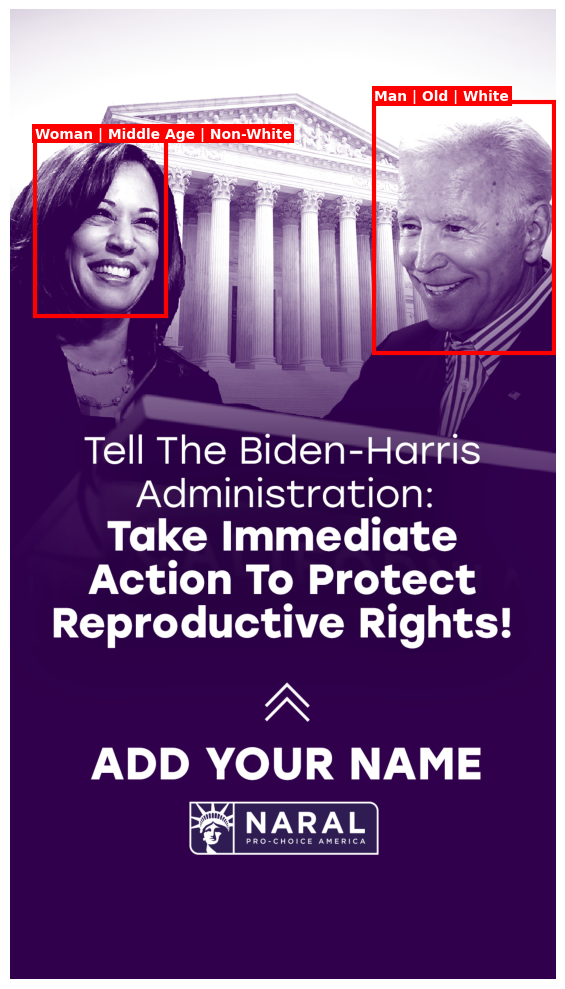

In [25]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

sample_id    = df_faces["id"].iloc[5]
sample_faces = df_faces[df_faces["id"] == sample_id]

img = Image.open(f"images/{sample_id}.png").convert("RGB")

fig, ax = plt.subplots(figsize=(14, 10))
ax.imshow(img)

for _, face in sample_faces.iterrows():
    x = face["x"] / 100 * face["img_width"]
    y = face["y"] / 100 * face["img_height"]
    w = face["width"]  / 100 * face["img_width"]
    h = face["height"] / 100 * face["img_height"]

    rect = patches.Rectangle((x, y), w, h, linewidth=3, edgecolor="red", facecolor="none")
    ax.add_patch(rect)

    label = f"{face['gender']} | {face['age']} | {face['ethnicity']}"
    ax.text(x, y - 5, label, color="white", fontsize=10, fontweight="bold",
            bbox=dict(facecolor="red", edgecolor="none", pad=2))

ax.axis("off")
plt.tight_layout()
plt.show()

In [1]:
!pip install facenet_pytorch

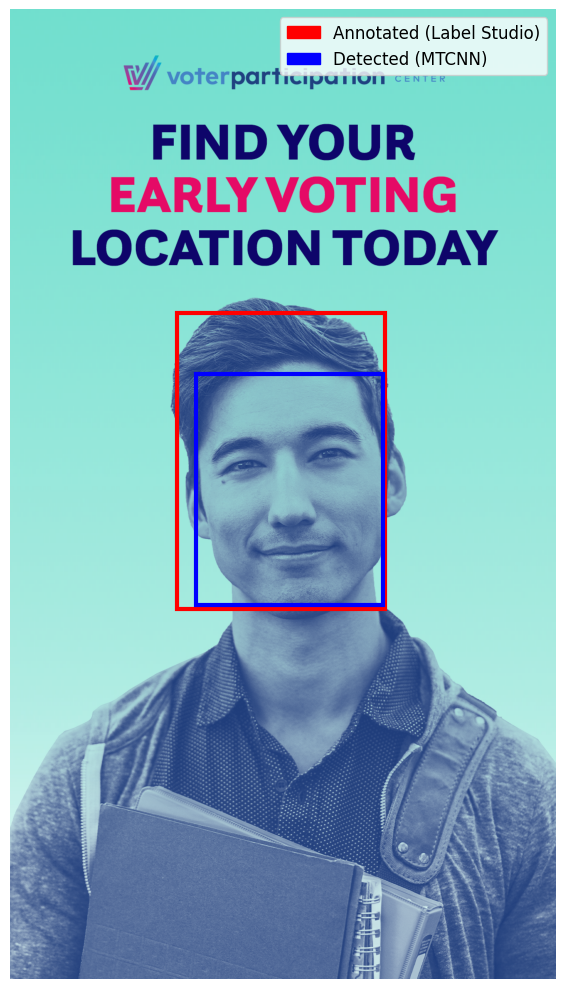

Annotated faces: 1
MTCNN detected:  1
  Face 1: x=369 y=721 w=370 h=458


In [32]:
from facenet_pytorch import MTCNN
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch

mtcnn = MTCNN(keep_all=True, device="cuda")

sample_id    = df_faces["id"].iloc[2]
sample_faces = df_faces[df_faces["id"] == sample_id]
img          = Image.open(f"images/{sample_id}.png").convert("RGB")

boxes_detected, _ = mtcnn.detect(img)

fig, ax = plt.subplots(figsize=(14, 10))
ax.imshow(img)

# Annotated boxes from Label Studio (red)
for _, face in sample_faces.iterrows():
    x = face["x"] / 100 * face["img_width"]
    y = face["y"] / 100 * face["img_height"]
    w = face["width"]  / 100 * face["img_width"]
    h = face["height"] / 100 * face["img_height"]
    ax.add_patch(patches.Rectangle((x, y), w, h, linewidth=3, edgecolor="red", facecolor="none"))


# MTCNN detected boxes (blue)
if boxes_detected is not None:
    for i, box in enumerate(boxes_detected):
        x1, y1, x2, y2 = box
        ax.add_patch(patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=3, edgecolor="blue", facecolor="none"))

ax.legend(handles=[
    patches.Patch(color="red",  label="Annotated (Label Studio)"),
    patches.Patch(color="blue", label="Detected (MTCNN)")
], fontsize=12)
ax.axis("off")
plt.tight_layout()
plt.show()

print(f"Annotated faces: {len(sample_faces)}")
print(f"MTCNN detected:  {len(boxes_detected) if boxes_detected is not None else 0}")

if boxes_detected is not None:
    for i, box in enumerate(boxes_detected):
        x1, y1, x2, y2 = box
        print(f"  Face {i+1}: x={x1:.0f} y={y1:.0f} w={x2-x1:.0f} h={y2-y1:.0f}")

In [34]:
!pip install timm -q

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import timm
import torch
import torch.nn as nn
import numpy as np
from PIL import Image

# ── Crop faces using Label Studio boxes ───────────────────────────────────
crops, labels_age, labels_gender, labels_ethnicity = [], [], [], []

for _, face in df_faces.iterrows():
    img_path = f"images/{face['id']}.png"
    if not os.path.exists(img_path):
        continue
    img = Image.open(img_path).convert("RGB")

    x = face["x"] / 100 * face["img_width"]
    y = face["y"] / 100 * face["img_height"]
    w = face["width"]  / 100 * face["img_width"]
    h = face["height"] / 100 * face["img_height"]

    crop = img.crop((x, y, x+w, y+h))

    # Skip if any label is missing
    if None in [face["age"], face["gender"], face["ethnicity"]]:
        continue

    crops.append(crop)
    labels_age.append(face["age"])
    labels_gender.append(face["gender"])
    labels_ethnicity.append(face["ethnicity"])

print(f"Total crops: {len(crops)}")

# ── Encode labels ─────────────────────────────────────────────────────────
le_age       = LabelEncoder().fit(labels_age)
le_gender    = LabelEncoder().fit(labels_gender)
le_ethnicity = LabelEncoder().fit(labels_ethnicity)

print(f"Age:       {list(le_age.classes_)}")
print(f"Gender:    {list(le_gender.classes_)}")
print(f"Ethnicity: {list(le_ethnicity.classes_)}")

y_age       = le_age.transform(labels_age)
y_gender    = le_gender.transform(labels_gender)
y_ethnicity = le_ethnicity.transform(labels_ethnicity)

# ── Dataset ───────────────────────────────────────────────────────────────
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

class FaceDataset(Dataset):
    def __init__(self, crops, age, gender, ethnicity):
        self.crops     = crops
        self.age       = age
        self.gender    = gender
        self.ethnicity = ethnicity

    def __len__(self):
        return len(self.crops)

    def __getitem__(self, i):
        return (
            transform(self.crops[i]),
            torch.tensor(self.age[i]),
            torch.tensor(self.gender[i]),
            torch.tensor(self.ethnicity[i])
        )

idx = list(range(len(crops)))
train_idx, test_idx = train_test_split(idx, test_size=0.2, random_state=42)

train_ds = FaceDataset([crops[i] for i in train_idx], y_age[train_idx], y_gender[train_idx], y_ethnicity[train_idx])
test_ds  = FaceDataset([crops[i] for i in test_idx],  y_age[test_idx],  y_gender[test_idx],  y_ethnicity[test_idx])

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=16)

# ── Multi-task model ──────────────────────────────────────────────────────
# One shared ViT backbone, three classification heads
class FaceClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone    = timm.create_model("vit_small_patch16_224", pretrained=True, num_classes=0)
        feat_dim         = self.backbone.num_features
        self.head_age       = nn.Linear(feat_dim, len(le_age.classes_))
        self.head_gender    = nn.Linear(feat_dim, len(le_gender.classes_))
        self.head_ethnicity = nn.Linear(feat_dim, len(le_ethnicity.classes_))

    def forward(self, x):
        feat = self.backbone(x)
        return self.head_age(feat), self.head_gender(feat), self.head_ethnicity(feat)

model     = FaceClassifier().to("cuda")
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4)
criterion = nn.CrossEntropyLoss()

# ── Train ─────────────────────────────────────────────────────────────────
for epoch in range(10):
    model.train()
    total_loss = 0
    for imgs, age, gender, ethnicity in train_loader:
        imgs, age, gender, ethnicity = imgs.to("cuda"), age.to("cuda"), gender.to("cuda"), ethnicity.to("cuda")

        out_age, out_gender, out_ethnicity = model(imgs)
        loss = criterion(out_age, age) + criterion(out_gender, gender) + criterion(out_ethnicity, ethnicity)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # ── Evaluate ──────────────────────────────────────────────────────────
    model.eval()
    correct_age = correct_gender = correct_ethnicity = 0
    with torch.no_grad():
        for imgs, age, gender, ethnicity in test_loader:
            imgs, age, gender, ethnicity = imgs.to("cuda"), age.to("cuda"), gender.to("cuda"), ethnicity.to("cuda")
            out_age, out_gender, out_ethnicity = model(imgs)
            correct_age       += (out_age.argmax(1)       == age).sum().item()
            correct_gender    += (out_gender.argmax(1)    == gender).sum().item()
            correct_ethnicity += (out_ethnicity.argmax(1) == ethnicity).sum().item()

    n = len(test_ds)
    print(f"Epoch {epoch+1:2d} | Loss: {total_loss/len(train_loader):.3f} | "
          f"Age: {correct_age/n:.2%} | Gender: {correct_gender/n:.2%} | Ethnicity: {correct_ethnicity/n:.2%}")

Total crops: 177
Age:       ['Middle Age', 'Old', 'Young']
Gender:    ['Man', 'Woman']
Ethnicity: ['Non-White', 'White']


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

Epoch  1 | Loss: 2.745 | Age: 52.78% | Gender: 75.00% | Ethnicity: 61.11%
Epoch  2 | Loss: 2.242 | Age: 52.78% | Gender: 75.00% | Ethnicity: 61.11%
Epoch  3 | Loss: 2.242 | Age: 52.78% | Gender: 75.00% | Ethnicity: 61.11%
Epoch  4 | Loss: 2.176 | Age: 52.78% | Gender: 75.00% | Ethnicity: 61.11%
Epoch  5 | Loss: 2.080 | Age: 52.78% | Gender: 83.33% | Ethnicity: 69.44%
Epoch  6 | Loss: 1.929 | Age: 58.33% | Gender: 77.78% | Ethnicity: 61.11%
Epoch  7 | Loss: 1.696 | Age: 61.11% | Gender: 69.44% | Ethnicity: 75.00%
Epoch  8 | Loss: 1.076 | Age: 63.89% | Gender: 66.67% | Ethnicity: 75.00%
Epoch  9 | Loss: 0.745 | Age: 69.44% | Gender: 69.44% | Ethnicity: 83.33%
Epoch 10 | Loss: 0.414 | Age: 63.89% | Gender: 69.44% | Ethnicity: 77.78%


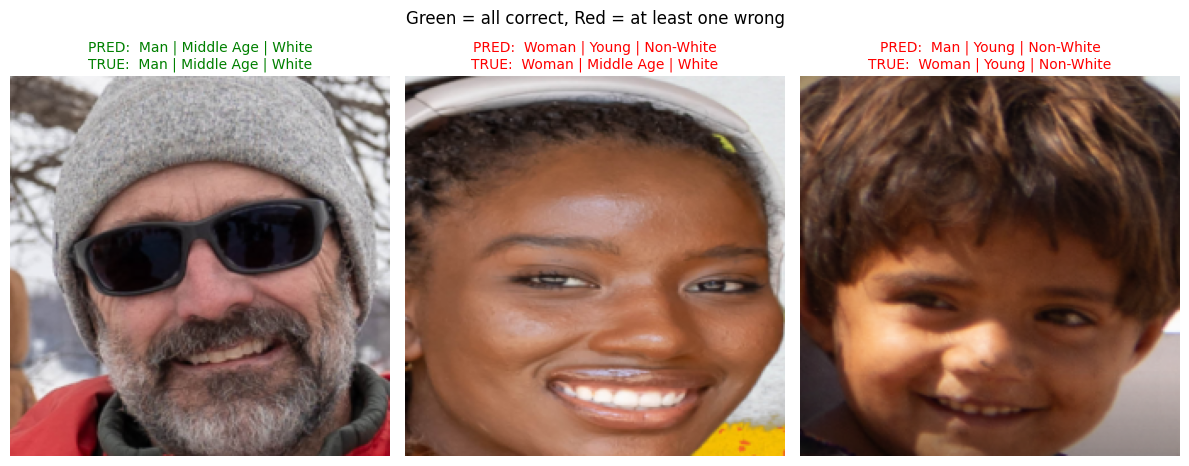

In [39]:
model.eval()

# ── Pick 3 faces from test set ────────────────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(12, 5))

for i in range(3):
    crop, true_age, true_gender, true_ethnicity = test_ds[i+7]

    # Predict
    with torch.no_grad():
        out_age, out_gender, out_ethnicity = model(crop.unsqueeze(0).to("cuda"))

    pred_age       = le_age.inverse_transform([out_age.argmax(1).item()])[0]
    pred_gender    = le_gender.inverse_transform([out_gender.argmax(1).item()])[0]
    pred_ethnicity = le_ethnicity.inverse_transform([out_ethnicity.argmax(1).item()])[0]

    true_age_str       = le_age.inverse_transform([true_age.item()])[0]
    true_gender_str    = le_gender.inverse_transform([true_gender.item()])[0]
    true_ethnicity_str = le_ethnicity.inverse_transform([true_ethnicity.item()])[0]

    # Unnormalize for display
    img_display = crop.permute(1, 2, 0).numpy()
    img_display = img_display * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    img_display = img_display.clip(0, 1)

    axes[i].imshow(img_display)
    axes[i].axis("off")
    axes[i].set_title(
        f"PRED:  {pred_gender} | {pred_age} | {pred_ethnicity}\n"
        f"TRUE:  {true_gender_str} | {true_age_str} | {true_ethnicity_str}",
        fontsize=10,
        color="green" if (pred_age == true_age_str and pred_gender == true_gender_str and pred_ethnicity == true_ethnicity_str) else "red"
    )

plt.suptitle("Green = all correct, Red = at least one wrong", fontsize=12)
plt.tight_layout()
plt.show()